In [1]:
# STEP 1: Import all required libraries (global scope)

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import h5py
import joblib
import pywt

from typing import List

from scipy.signal import butter, filtfilt, find_peaks, savgol_filter
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


/home/user1/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/user1/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/user1/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# STEP 2: HDF5 inspection and streaming utilities

def inspect_h5(h5_path):
    with h5py.File(h5_path, "r") as f:
        def print_group(g, indent=0):
            for k, v in g.items():
                if isinstance(v, h5py.Dataset):
                    print("  " * indent + f"- {k} (Dataset) shape={v.shape} dtype={v.dtype}")
                else:
                    print("  " * indent + f"- {k} (Group)")
                    print_group(v, indent + 1)
        print_group(f)

def iter_h5_windows(h5_path, window_key="windows", label_key="labels", chunk_size=512):
    with h5py.File(h5_path, "r") as f:
        if window_key not in f or label_key not in f:
            raise KeyError(f"Keys not found in HDF5. Found top-level keys: {list(f.keys())}")
        w = f[window_key]
        lbl = f[label_key]
        total = w.shape[0]
        for i in range(0, total, chunk_size):
            j = min(total, i + chunk_size)
            yield w[i:j], lbl[i:j]

def load_small_sample(h5_path, window_key="windows", label_key="labels", n=1000):
    with h5py.File(h5_path, "r") as f:
        w = f[window_key][:n]
        lbl = f[label_key][:n]
    return w, lbl


In [3]:
# STEP 3: PPG denoising, filtering, and normalization utilities

def bandpass_filter(sig, fs, low=0.5, high=8.0, order=4):
    nyq = 0.5 * fs
    lowcut = low / nyq
    highcut = high / nyq
    b, a = butter(order, [lowcut, highcut], btype="band")
    return filtfilt(b, a, sig)

def wavelet_denoise(sig, wavelet="db6", level=None):
    if level is None:
        level = 3
    coeffs = pywt.wavedec(sig, wavelet, mode="symmetric")
    sigma = (np.median(np.abs(coeffs[-level])) / 0.6745) if len(coeffs) > level else (np.std(sig) + 1e-8)
    uthresh = sigma * np.sqrt(2 * np.log(len(sig)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=uthresh, mode="soft") for c in coeffs[1:]]
    denoised = pywt.waverec(denoised_coeffs, wavelet, mode="symmetric")
    return denoised[:len(sig)]

def denoise_ppg_window(window, fs, use_tqwt=False):
    sig = np.asarray(window, dtype=float)
    try:
        bp = bandpass_filter(sig, fs)
    except Exception:
        bp = sig - np.mean(sig)
    den = wavelet_denoise(bp)
    wlen = 9 if len(den) >= 9 else (len(den) - 1 if (len(den) % 2 == 0) else len(den))
    if wlen >= 5:
        den = savgol_filter(den, window_length=wlen, polyorder=3)
    return den

def zscore_normalize(window):
    w = np.asarray(window, dtype=float)
    return (w - np.mean(w)) / (np.std(w) + 1e-8)

def minmax_normalize(window):
    w = np.asarray(window, dtype=float)
    denom = (np.max(w) - np.min(w)) or 1.0
    return (w - np.min(w)) / denom

def detect_peaks_ppg(sig, fs, min_hr=40, max_hr=200, prominence=None):
    if prominence is None:
        prominence = 0.3 * (np.max(sig) - np.min(sig) + 1e-8)
    min_dist_samples = int(fs * 60 / max_hr)
    peaks, props = find_peaks(sig, distance=min_dist_samples, prominence=prominence)
    return peaks, props


In [4]:
# STEP 4: Morphological, derivative, and frequency-domain feature extraction
def _second_derivative(sig):
    return np.gradient(np.gradient(sig))

def extract_morphological_features(ppg_window, fs):
    x = np.asarray(ppg_window, dtype=float)
    features = {}

    features['mean'] = np.mean(x)
    features['std'] = np.std(x)
    features['min'] = np.min(x)
    features['max'] = np.max(x)
    features['skew'] = float(skew(x))
    features['kurtosis'] = float(kurtosis(x))

    prom = 0.25 * (features['max'] - features['min'] + 1e-8)
    peaks, _ = find_peaks(x, prominence=prom, distance=int(0.4 * fs))
    troughs, _ = find_peaks(-x, prominence=prom, distance=int(0.4 * fs))

    if len(peaks) >= 1:
        systolic_values = x[peaks]
        features['systolic_peak_mean'] = float(np.mean(systolic_values))
        features['systolic_peak_std'] = float(np.std(systolic_values))
        features['peak_count'] = int(len(peaks))
        features['pp_amp'] = float(np.mean(systolic_values) - np.mean(x))
    else:
        features.update(dict.fromkeys(
            ['systolic_peak_mean','systolic_peak_std','peak_count','pp_amp'], 0.0))

    if len(peaks) >= 2:
        ppi = np.diff(peaks) / fs
        features['mean_ppi'] = float(np.mean(ppi))
        features['std_ppi'] = float(np.std(ppi))
        features['median_ppi'] = float(np.median(ppi))
    else:
        features.update(dict.fromkeys(['mean_ppi','std_ppi','median_ppi'], 0.0))

    dv = np.gradient(x)
    features['dv_mean'] = float(np.mean(dv))
    features['dv_max'] = float(np.max(dv))
    features['dv_min'] = float(np.min(dv))
    features['dv_skew'] = float(skew(dv))
    features['dv_kurtosis'] = float(kurtosis(dv))

    apg = _second_derivative(x)
    a_peaks, _ = find_peaks(apg, distance=int(0.2 * fs))
    neg_peaks, _ = find_peaks(-apg, distance=int(0.2 * fs))
    features['apg_a_count'] = int(len(a_peaks))
    features['apg_neg_count'] = int(len(neg_peaks))
    features['b_by_a'] = float(abs(apg[neg_peaks[0]]) / (abs(apg[a_peaks[0]]) + 1e-8)) if len(a_peaks) and len(neg_peaks) else 0.0

    features['auc'] = float(np.trapz(x))

    N = len(x)
    if N > 1:
        yf = np.abs(rfft(x))
        xf = rfftfreq(N, 1.0 / fs)
        idx = np.argmax(yf)
        features['dominant_freq'] = float(xf[idx])
        features['energy_0_4'] = float(np.sum(yf[(xf >= 0.5) & (xf <= 4.0)]) / (np.sum(yf) + 1e-8))
        features['energy_4_8'] = float(np.sum(yf[(xf > 4.0) & (xf <= 8.0)]) / (np.sum(yf) + 1e-8))
    else:
        features.update(dict.fromkeys(['dominant_freq','energy_0_4','energy_4_8'], 0.0))

    return features

def extract_features_for_batch(windows_batch, fs):
    return [extract_morphological_features(w, fs) for w in windows_batch]


In [5]:
# STEP 5: Regression models, tuning, ensembling, and evaluation


def split_features_labels(df, target_cols=['SBP','DBP','ABP']):
    X = df.drop(columns=[c for c in target_cols if c in df.columns]).values
    y = df[target_cols].values
    return X, y

def evaluate_regression_model(model, X, y):
    preds = model.predict(X)
    metrics = {}
    for i in range(y.shape[1]):
        metrics[i] = {
            "MAE": mean_absolute_error(y[:,i], preds[:,i]),
            "RMSE": mean_squared_error(y[:,i], preds[:,i], squared=False),
            "R2": r2_score(y[:,i], preds[:,i])
        }
    metrics['mean_MAE'] = np.mean([metrics[i]['MAE'] for i in range(y.shape[1])])
    return metrics

def train_and_tune(X, y, target_idx=0, cv_splits=4):
    y_single = y[:, target_idx]
    X_train, X_test, y_train, y_test = train_test_split(X, y_single, test_size=0.2, random_state=42)

    pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])
    pipe_svr = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
    pipe_rf  = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(n_jobs=-1, random_state=42))])

    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    gs_knn = GridSearchCV(pipe_knn, {'knn__n_neighbors':[3,5,7,9]}, cv=cv, scoring='neg_mean_absolute_error')
    gs_svr = GridSearchCV(pipe_svr, {'svr__C':[0.1,1,10]}, cv=cv, scoring='neg_mean_absolute_error')
    gs_rf  = GridSearchCV(pipe_rf,  {'rf__n_estimators':[100,200]}, cv=cv, scoring='neg_mean_absolute_error')

    gs_knn.fit(X_train, y_train)
    gs_svr.fit(X_train, y_train)
    gs_rf.fit(X_train, y_train)

    voting = VotingRegressor([
        ('knn', gs_knn.best_estimator_),
        ('svr', gs_svr.best_estimator_),
        ('rf',  gs_rf.best_estimator_)
    ])
    voting.fit(X_train, y_train)

    stacking = StackingRegressor(
        estimators=voting.estimators,
        final_estimator=Ridge()
    )
    stacking.fit(X_train, y_train)

    return {
        'voting': (voting, evaluate_regression_model(voting, X_test, y_test.reshape(-1,1))),
        'stacking': (stacking, evaluate_regression_model(stacking, X_test, y_test.reshape(-1,1))),
        'X_test': X_test,
        'y_test': y_test
    }


In [6]:
# STEP 6: Saving/loading features and trained models

def save_features_to_parquet(features_list, labels_array, out_path):
    df = pd.DataFrame(features_list)
    sbp, dbp = labels_array[:,0], labels_array[:,1]
    df['SBP'] = sbp
    df['DBP'] = dbp
    df['ABP'] = (sbp + 2 * dbp) / 3
    df.to_parquet(out_path)
    return df

def load_features_from_parquet(path):
    return pd.read_parquet(path)

def save_model(model, path):
    joblib.dump(model, path)

def load_model(path):
    return joblib.load(path)



In [7]:
# STEP 7: User configuration and pipeline parameters

h5_path = "/home/user1/komendra/ml_ppg_data/trial/data/MIMIC-III_ppg_dataset.h5"
window_key = "ppg"
label_key = "label"
fs = 125
chunk_size = 1024

features_parquet = "outputs/features.parquet"
models_dir = "outputs/models"

os.makedirs(models_dir, exist_ok=True)
os.makedirs("outputs", exist_ok=True)


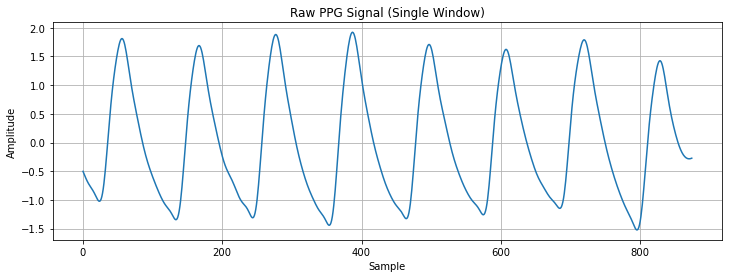

In [8]:
# STEP 8: Visualization – raw PPG signal (before preprocessing)

raw_windows, raw_labels = load_small_sample(
    h5_path, window_key=window_key, label_key=label_key, n=1
)

raw_ppg = raw_windows[0]

plt.figure(figsize=(12,4))
plt.plot(raw_ppg)
plt.title("Raw PPG Signal (Single Window)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


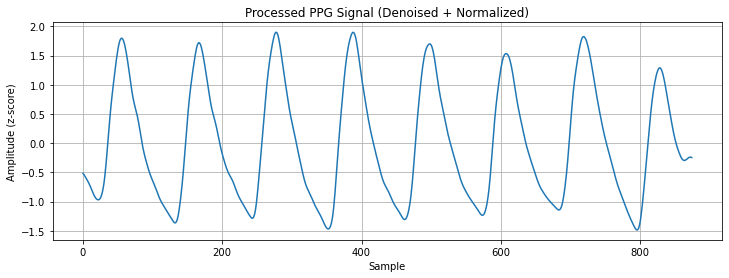

In [9]:
# STEP 9: Visualization – processed PPG signal (after preprocessing)

processed_ppg = zscore_normalize(denoise_ppg_window(raw_ppg, fs))

plt.figure(figsize=(12,4))
plt.plot(processed_ppg)
plt.title("Processed PPG Signal (Denoised + Normalized)")
plt.xlabel("Sample")
plt.ylabel("Amplitude (z-score)")
plt.grid(True)
plt.show()


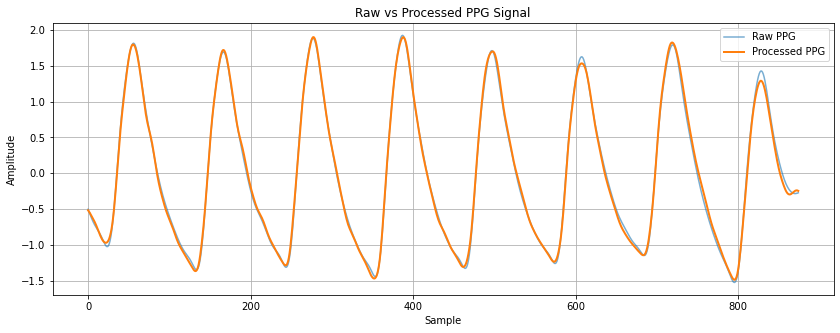

In [10]:
# STEP 10: Visualization – raw vs processed PPG comparison

plt.figure(figsize=(14,5))
plt.plot(raw_ppg, label="Raw PPG", alpha=0.6)
plt.plot(processed_ppg, label="Processed PPG", linewidth=2)
plt.legend()
plt.title("Raw vs Processed PPG Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [11]:
# STEP 11: Stream HDF5, preprocess windows, extract features, save parquet


def build_feature_table_from_h5():
    feats, labels = [], []
    inspect_h5(h5_path)
    for w_chunk, l_chunk in iter_h5_windows(h5_path, window_key, label_key, chunk_size):
        den = np.stack([zscore_normalize(denoise_ppg_window(w, fs)) for w in w_chunk])
        feats.extend(extract_features_for_batch(den, fs))
        labels.extend(l_chunk)
    return save_features_to_parquet(feats, np.array(labels), features_parquet)

if not os.path.exists(features_parquet):
    build_feature_table_from_h5()

df = load_features_from_parquet(features_parquet)
X, y = split_features_labels(df)

for i, name in enumerate(['SBP','DBP','ABP']):
    results = train_and_tune(X, y, target_idx=i)
    best = min(results, key=lambda k: results[k][1]['mean_MAE'] if k in ['voting','stacking'] else np.inf)
    save_model(results[best][0], f"{models_dir}/{name}.joblib")

- label (Dataset) shape=(9054000, 2) dtype=int64
- ppg (Dataset) shape=(9054000, 875) dtype=float32
- subject_idx (Dataset) shape=(9054000, 1) dtype=int64


In [ ]:
# STEP 12: Visualization – feature distributions

df = load_features_from_parquet(features_parquet)

df.hist(figsize=(16,12), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


In [ ]:
# STEP 13: Train and tune models for each BP target

X, y = split_features_labels(df)

results_all = {}

for i, name in enumerate(['SBP','DBP','ABP']):
    results = train_and_tune(X, y, target_idx=i)
    results_all[name] = results


In [ ]:
# STEP 14: Visualization – predicted vs true BP values

for name, res in results_all.items():
    model = res['voting'][0]
    X_test = res['X_test']
    y_test = res['y_test']
    preds = model.predict(X_test)

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, preds, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--')
    plt.xlabel("True " + name)
    plt.ylabel("Predicted " + name)
    plt.title(f"{name}: Prediction vs Ground Truth")
    plt.grid(True)
    plt.show()


In [ ]:
# STEP 15: Visualization – prediction error distributions

for name, res in results_all.items():
    model = res['voting'][0]
    X_test = res['X_test']
    y_test = res['y_test']
    errors = model.predict(X_test) - y_test

    plt.figure(figsize=(8,4))
    plt.hist(errors, bins=40)
    plt.title(f"{name} Prediction Error Distribution")
    plt.xlabel("Error (mmHg)")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


In [ ]:
# STEP 16: Numerical evaluation metrics (MAE, RMSE, R2)

for name, res in results_all.items():
    model = res['voting'][0]
    X_test = res['X_test']
    y_test = res['y_test']
    preds = model.predict(X_test)

    print(f"\n{name} Metrics")
    print("-" * 30)
    print("MAE :", mean_absolute_error(y_test, preds))
    print("RMSE:", mean_squared_error(y_test, preds, squared=False))
    print("R2  :", r2_score(y_test, preds))


In [ ]:
# STEP 17: Bland–Altman plots for BP estimation

for name, res in results_all.items():
    model = res['voting'][0]
    X_test = res['X_test']
    y_test = res['y_test']
    preds = model.predict(X_test)

    mean_vals = (y_test + preds) / 2
    diff_vals = preds - y_test

    plt.figure(figsize=(8,5))
    plt.scatter(mean_vals, diff_vals, alpha=0.4)
    plt.axhline(np.mean(diff_vals), color='r', linestyle='--', label='Mean Error')
    plt.axhline(np.mean(diff_vals) + 1.96*np.std(diff_vals), color='gray', linestyle='--')
    plt.axhline(np.mean(diff_vals) - 1.96*np.std(diff_vals), color='gray', linestyle='--')

    plt.title(f"Bland–Altman Plot ({name})")
    plt.xlabel("Mean of True and Predicted (mmHg)")
    plt.ylabel("Prediction Error (mmHg)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# STEP 18: Absolute error CDF (clinical accuracy visualization)

for name, res in results_all.items():
    model = res['voting'][0]
    X_test = res['X_test']
    y_test = res['y_test']
    abs_err = np.abs(model.predict(X_test) - y_test)

    sorted_err = np.sort(abs_err)
    cdf = np.arange(len(sorted_err)) / len(sorted_err)

    plt.figure(figsize=(6,4))
    plt.plot(sorted_err, cdf)
    plt.xlabel("Absolute Error (mmHg)")
    plt.ylabel("Cumulative Probability")
    plt.title(f"{name} Absolute Error CDF")
    plt.grid(True)
    plt.show()


In [ ]:
# STEP 19: Accuracy under clinical thresholds (AAMI-style)

thresholds = [5, 10, 15]

for name, res in results_all.items():
    model = res['voting'][0]
    X_test = res['X_test']
    y_test = res['y_test']
    abs_err = np.abs(model.predict(X_test) - y_test)

    print(f"\n{name} Accuracy")
    for t in thresholds:
        pct = np.mean(abs_err <= t) * 100
        print(f"  |Error| ≤ {t} mmHg: {pct:.2f}%")


In [ ]:
# STEP 20: Binned confusion matrix (clinical BP categories)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def bin_bp(values):
    bins = [0, 90, 120, 140, 300]
    return np.digitize(values, bins)

for name, res in results_all.items():
    model = res['voting'][0]
    X_test = res['X_test']
    y_test = res['y_test']
    preds = model.predict(X_test)

    y_true_bin = bin_bp(y_test)
    y_pred_bin = bin_bp(preds)

    cm = confusion_matrix(y_true_bin, y_pred_bin)

    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Binned Confusion Matrix")
    plt.show()


In [ ]:
# STEP 21: Classification report (BP stage classification)

from sklearn.metrics import classification_report

def bin_sbp(values):
    """
    SBP clinical categories:
    0: Hypotension (<90)
    1: Normal (90–120)
    2: Elevated (120–140)
    3: Hypertension (>=140)
    """
    bins = [0, 90, 120, 140, 300]
    return np.digitize(values, bins) - 1


def bin_dbp(values):
    """
    DBP clinical categories:
    0: Hypotension (<60)
    1: Normal (60–80)
    2: Elevated (80–90)
    3: Hypertension (>=90)
    """
    bins = [0, 60, 80, 90, 200]
    return np.digitize(values, bins) - 1


def bin_map(values):
    """
    MAP categories:
    0: Low (<65)
    1: Normal (65–100)
    2: High (>100)
    """
    bins = [0, 65, 100, 200]
    return np.digitize(values, bins) - 1


for name, res in results_all.items():
    model = res['voting'][0]
    X_test = res['X_test']
    y_test = res['y_test']
    preds = model.predict(X_test)

    if name == 'SBP':
        y_true_cls = bin_sbp(y_test)
        y_pred_cls = bin_sbp(preds)
        target_names = ['Hypotension', 'Normal', 'Elevated', 'Hypertension']

    elif name == 'DBP':
        y_true_cls = bin_dbp(y_test)
        y_pred_cls = bin_dbp(preds)
        target_names = ['Hypotension', 'Normal', 'Elevated', 'Hypertension']

    else:  # MAP / ABP
        y_true_cls = bin_map(y_test)
        y_pred_cls = bin_map(preds)
        target_names = ['Low', 'Normal', 'High']

    print(f"\nClassification Report for {name}")
    print("-" * 50)
    print(classification_report(
        y_true_cls,
        y_pred_cls,
        target_names=target_names,
        zero_division=0
    ))
